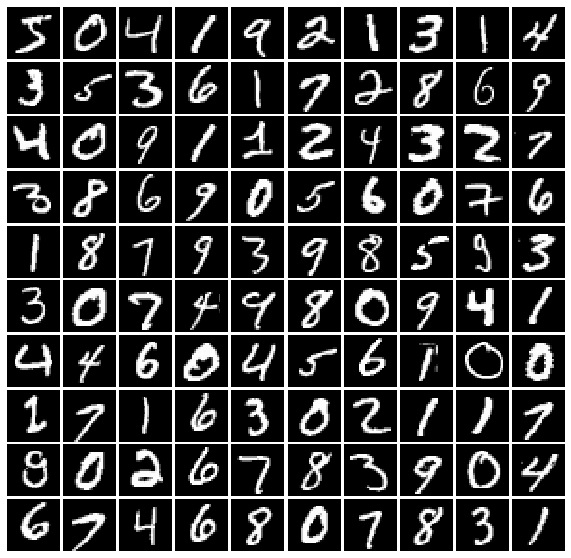

RuntimeError: CUDA error: out of memory

In [2]:
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils.data import DataLoader, sampler
from torch.autograd import Variable
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# 超参数设置
batch_size = 100
NOISE_DIM = 96
NUM_TRAIN = 500
NUM_VAL = 50
def deprocess_img(x):
    return (x+1.0)/2.0

# 定义一个采样函数
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    plt.show()
    return
data_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_set = datasets.MNIST('./', train=True, download=True, transform=data_tf)
# 取MNIST训练集的前50000张作为train_data
train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))
val_set = datasets.MNIST('./', train=True, download=True, transform=data_tf)
# 取MNIST训练集索引为50000-55000的5000张图片作为val_data
val_data = DataLoader(val_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze()
show_images(imgs)

# 定义判别器
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv1 = nn.Sequential(                     # b, 1, 28, 28
            nn.Conv2d(1, 32, kernel_size=5, padding=2),   # b, 32, 28, 28
            nn.LeakyReLU(0.2, True),
            nn.AvgPool2d(2, 2)          # b, 32, 14, 14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # b, 64, 14, 14
            nn.LeakyReLU(0.2, True),
            nn.AvgPool2d(2, 2)    # b, 64, 7, 7
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 32),
            nn.LeakyReLU(0.2, True),
            nn.Linear(32, 1),
            nn.Sigmoid()   # 将输出映射到(0, 1)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class generator(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM):
        super(generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 3*3*128),
            nn.ReLU(True),
            nn.BatchNorm1d(3 * 3 * 128),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # b, 64, 14, 14
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),    # b, 1, 28, 28
            nn.Tanh()
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 7, 7)
        x = self.conv(x)
        return x

bce_loss = nn.BCEWithLogitsLoss()

# 定义判别器的损失函数
def discriminator_loss(logits_real, logits_fake):
    size = logits_real.size(0)
    true_labels = Variable(torch.ones(size, 1).float().cuda())
    false_labels = Variable(torch.zeros(size, 1).float().cuda())
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss

# 定义生成器的损失函数
def generator_loss(logits_fake):
    size = logits_fake.size(0)
    true_labels = Variable(torch.ones(size, 1).float().cuda())
    loss = bce_loss(logits_fake, true_labels)
    return loss

# 定义优化器
def get_optimizer(net):
    optimizer = optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

# 定义训练函数
def train_gan(D_net, G_net, D_optimizer, G_optimizer,
              show_every=250, noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.size(0)
            # 判别网络
            real_data = Variable(x).cuda()
            logits_real = D_net(real_data)

            # 使用先验分布torch.rand()产生区间(0, 1)间的数据
            sample_noise = (torch.rand(bs, noise_size) - 0.5)/0.5   # ([-1, 1])
            g_fake_seed = Variable(sample_noise).cuda()
            # 生成假的数据
            fake_images = G_net(g_fake_seed)
            # 生成数据送入判别器的得分
            logits_fake = D_net(fake_images)
            # 判别器的误差函数
            discriminator_error = discriminator_loss(logits_real, logits_fake)
            D_optimizer.zero_grad()
            discriminator_error.backward()
            D_optimizer.step()

            # 使用生成网络产生新的数据
            sample_noise = (torch.rand(bs, noise_size) - 0.5)/0.5
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed)
            logits_fake = D_net(fake_images)
            generator_error = generator_loss(logits_fake)
            G_optimizer.zero_grad()
            generator_error.backward()
            G_optimizer.step()

            if (iter_count % show_every == 0):
                print("epoch: {}, Iter: {}, D:{:.4}, G:{:.4}".format(epoch, iter_count, discriminator_error.data, generator_error.data))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy)
                print("iter_count: {}".format(iter_count))
            iter_count += 1

# 开始训练
D_net = discriminator().cuda()
G_net = generator().cuda()

D_optimizer = get_optimizer(D_net)
G_optimizer = get_optimizer(G_net)

train_gan(D_net, G_net, D_optimizer, G_optimizer, num_epochs=20)